<a href="https://colab.research.google.com/github/stellagerantoni/LatentCfMultivariate/blob/main/multivariate_pendigits_with_KDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/stellagerantoni/LatentCfMultivariate

Cloning into 'LatentCfMultivariate'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 71 (delta 37), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (71/71), 3.72 MiB | 9.14 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [2]:
!pip install -q wildboar
!pip install -q scikit-learn
!pip install -q stumpy
!pip install -q fastdtw
!pip install aeon[all_extras]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 65.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [3]:
import logging
import os
import warnings
from argparse import ArgumentParser
from aeon.datasets import load_classification

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.spatial import distance_matrix
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from wildboar.datasets import load_dataset
from wildboar.ensemble import ShapeletForestClassifier
from wildboar.explain.counterfactual import counterfactuals
%cd '/content/LatentCfMultivariate'
from _guided import ModifiedLatentCF
from help_functions import *
from keras_models import *

/content/LatentCfMultivariate


In [4]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
RANDOM_STATE = 39

## **FUNCTIONS**

In [5]:
def load_dataset(dataset):
  X, y, meta_data = load_classification(dataset)
  if dataset == 'Heartbeat':
    pos = 'normal'
    neg = 'abnormal'
    X = X.transpose(0,2,1)
  if dataset == 'SelfRegulationSCP1':
    pos = 'positivity'
    neg = 'negativity'
    X = X.transpose(0,2,1)
  if dataset == 'Cricket':
    return X,y,meta_data
  if dataset == 'SpokenArabicDigits':
    return X,y,meta_data
  if dataset == 'PenDigits':
    return X,y,meta_data

  print(" Shape of X = ", X.shape)
  print(" Shape of y = ", y.shape)
  print(" Meta data = ", meta_data)
  # Convert positive and negative labels to 1 and 0
  pos_label, neg_label = 1, 0
  if pos != pos_label:
      y[y==pos] = pos_label # convert/normalize positive label to 1
  if neg != neg_label:
      y[y==neg] = neg_label # convert negative label to 0

  y = y.astype(int)
  print(f"\n X[:1] = \n{X[:1]}")
  return X,y,pos_label, neg_label

# **ACTUALL CODE**
datasets available : 'Heartbeat', 'SelfRegulationSCP1'

In [6]:
RANDOM_STATE = 39
X,y,data_information = load_dataset('PenDigits')
print(f'shape of X = {X.shape}')
print(f'shape of y = {y.shape}')
print(f'data imformation = {data_information}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f'shape of X train = {X_train.shape}')
print(f'shape of y train = {y_train.shape}')

shape of X = (10992, 2, 8)
shape of y = (10992,)
data imformation = {'problemname': 'pendigits', 'timestamps': False, 'missing': False, 'univariate': False, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}
shape of X train = (8793, 2, 8)
shape of y train = (8793,)


In [7]:
# Upsample the minority class
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'before: {class_counts}')
X_train,y_train = upsample_minority_multivariate(X_train,y_train)
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f'after: {class_counts}')

before: [914 914 915 844 915 844 845 914 844 844]
after: [915 915 915 915 915 915 915 915 915 915]


In [8]:
X_train = X_train.transpose (0,2,1)
X_test = X_test.transpose(0,2,1)
n_training,n_timesteps, n_features= X_train.shape

X_train_processed, trained_scaler =  normalize_multivariate(data=X_train, n_timesteps=n_timesteps, n_features = n_features)
X_test_processed, _ =  normalize_multivariate(data=X_test, n_timesteps=n_timesteps, scaler=trained_scaler, n_features = n_features)

X_train_processed_padded, padding_size = conditional_pad_multivariate(X_train_processed) # add extra padding zeros if n_timesteps cannot be divided by 4, required for 1dCNN autoencoder structure
X_test_processed_padded, _ = conditional_pad_multivariate(X_test_processed)

n_timesteps_padded = X_train_processed_padded.shape[1]
print(f"Data pre-processed, original #timesteps={n_timesteps}, padded #timesteps={n_timesteps_padded}.")

#check the processing (0,1) min should be min 0 and max should be max 1
print(f"\nmin value = {np.min(X_train)}, max value = {np.max(X_train)}")
print(f"min value normalized = {np.min(X_train_processed)}, max value normalized= {np.max(X_train_processed)}")

#check that padding paddes the right dimention
print(f"\nX_train.shape = {X_train.shape}" )
print(f"X_train_processed_padded.shape = {X_train_processed_padded.shape}")


Data pre-processed, original #timesteps=8, padded #timesteps=8.

min value = 0.0, max value = 100.0
min value normalized = 0.0, max value normalized= 1.0

X_train.shape = (9150, 8, 2)
X_train_processed_padded.shape = (9150, 8, 2)


y = 9


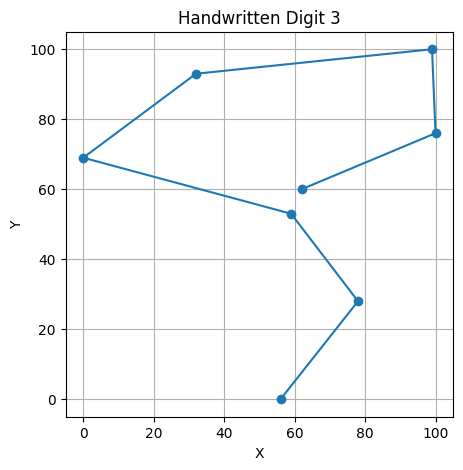

In [9]:
visualise_digit(X_train,y_train,9100)

In [10]:
X_train, y_train, X_test, y_test= extract_two_digits(X_train_processed_padded,y_train,X_test_processed_padded,y_test,'0','8',RANDOM_STATE)

Class 0 represents number 0. [1.,0.]
Class 1 represents number 8. [0.,1.]


y = 0


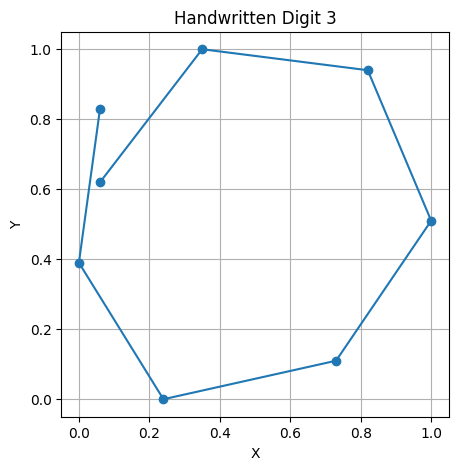

In [11]:
visualise_digit(X_train,y_train,100)

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)


In [13]:
print(f'X_train = {X_train.shape}')
print(f'X_validation = {X_validation.shape}')
print(f'X_test = {X_test.shape}')

y_train_classes = y_train
y_validation_classes = y_validation
y_test_classes = y_test

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, len(np.unique(y_train)))
y_validation = to_categorical(y_validation, len(np.unique(y_validation)))
y_test = to_categorical(y_test, len(np.unique(y_test)))

print(f'\ny_train_classes = {y_train_classes.shape}, y_validation_classes = {y_validation_classes.shape}, y_test_classes = {y_test_classes.shape}')
print(f'y_train = {y_train.shape}, y_validation = {y_validation.shape}, y_test= {y_test.shape}')

X_train = (1464, 8, 2)
X_validation = (366, 8, 2)
X_test = (440, 8, 2)

y_train_classes = (1464,), y_validation_classes = (366,), y_test_classes = (440,)
y_train = (1464, 2), y_validation = (366, 2), y_test= (440, 2)


y = 0


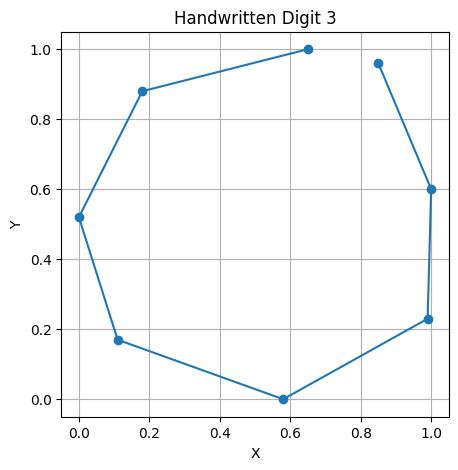

In [14]:
visualise_digit(X_train,y_train_classes,100)

In [15]:


# ## 2. LatentCF models
# reset seeds for numpy, tensorflow, python random package and python environment seed
reset_seeds()
###############################################
# ### 1dCNN classifier

cnnClassifier = Classifier(
    n_timesteps_padded, n_features, n_output=2, add_dense_layer = False
)

optimizer = keras.optimizers.Adam(lr=0.001)
cnnClassifier.compile(
    optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
)

# Define the early stopping criteria
early_stopping_accuracy = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=15, restore_best_weights=True
)
# Train the model
reset_seeds()
print("Training log for LSTM-FCN classifier:")
classifier_history = cnnClassifier.fit(
    X_train,
    y_train,
    epochs=150,
    batch_size=12,
    shuffle=True,
    verbose=True,
    validation_data=(X_validation, y_validation),
    callbacks=[early_stopping_accuracy],
)

y_pred = cnnClassifier.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
acc = balanced_accuracy_score(y_true=y_test_classes, y_pred=y_pred_classes)
print(f"LSTM-FCN classifier trained, with validation accuracy {acc}.")

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=y_test_classes, y_pred=y_pred_classes, labels=[1, 0]),
    index=["True:8", "True:0"],
    columns=["Pred:8", "Pred:0"],
)
print(confusion_matrix_df)


Training log for LSTM-FCN classifier:
Epoch 1/150
122/122 [==============================] - 15s 22ms/step - loss: 0.2667 - accuracy: 0.9351 - val_loss: 0.5367 - val_accuracy: 0.9672
Epoch 2/150
122/122 [==============================] - 1s 10ms/step - loss: 0.1068 - accuracy: 0.9843 - val_loss: 0.3414 - val_accuracy: 0.9809
Epoch 3/150
122/122 [==============================] - 1s 6ms/step - loss: 0.0813 - accuracy: 0.9945 - val_loss: 0.1930 - val_accuracy: 0.9973
Epoch 4/150
122/122 [==============================] - 1s 5ms/step - loss: 0.0698 - accuracy: 0.9952 - val_loss: 0.0992 - val_accuracy: 0.9973
Epoch 5/150
122/122 [==============================] - 1s 7ms/step - loss: 0.0625 - accuracy: 0.9959 - val_loss: 0.0692 - val_accuracy: 0.9973
Epoch 6/150
122/122 [==============================] - 1s 7ms/step - loss: 0.0542 - accuracy: 0.9986 - val_loss: 0.0574 - val_accuracy: 0.9973
Epoch 7/150
122/122 [==============================] - 1s 6ms/step - loss: 0.0500 - accuracy: 1.0000 

In [16]:
reset_seeds()


# ### 1dCNN autoencoder
autoencoder = Autoencoder( n_timesteps_padded,n_features,32)
optimizer = keras.optimizers.Adam(lr=0.0005)
autoencoder.compile(optimizer=optimizer, loss="mse")

# Define the early stopping criteria
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, restore_best_weights=True)
# Train the model
reset_seeds()
print("Training log for 1dCNN autoencoder:")
autoencoder_history = autoencoder.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=12,
    shuffle=True,
    verbose=2,
    validation_data=(X_validation, X_validation),
    callbacks=[early_stopping])

ae_val_loss = np.min(autoencoder_history.history['val_loss'])
print(f"1dCNN autoencoder trained, with validation loss: {ae_val_loss}.")


(None, 8, 2)
(None, 8, 32)
(None, 4, 32)
(None, 4, 16)
(None, 2, 16)
(None, 2, 16)
(None, 4, 16)
(None, 4, 32)
(None, 8, 32)
(None, 8, 2)


Training log for 1dCNN autoencoder:
Epoch 1/50
122/122 - 9s - loss: 0.1447 - val_loss: 0.0485 - 9s/epoch - 72ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0325 - val_loss: 0.0224 - 1s/epoch - 9ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0175 - val_loss: 0.0143 - 1s/epoch - 10ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0120 - val_loss: 0.0102 - 837ms/epoch - 7ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0089 - val_loss: 0.0078 - 655ms/epoch - 5ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0072 - val_loss: 0.0065 - 1s/epoch - 9ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0062 - val_loss: 0.0059 - 1s/epoch - 8ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0055 - val_loss: 0.0052 - 902ms/epoch - 7ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0049 - val_loss: 0.0050 - 1s/epoch - 8ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0046 - val_loss: 0.0046 - 706ms/epoch - 6ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0042 - val_loss: 0.0043 - 1s/epoch - 9ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0039 - val_loss: 0.0040 - 778ms/e

1/1 [==============================] - 0s 144ms/step
y = [[0. 1.]]


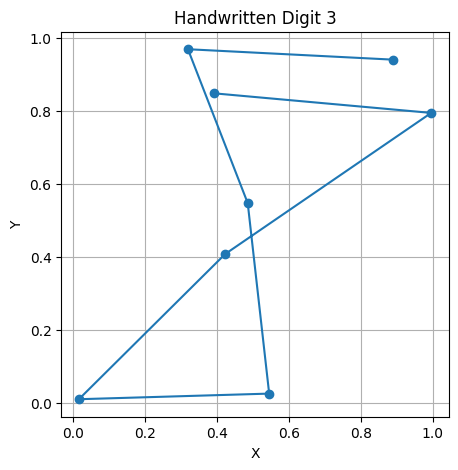

y = [0. 1.]


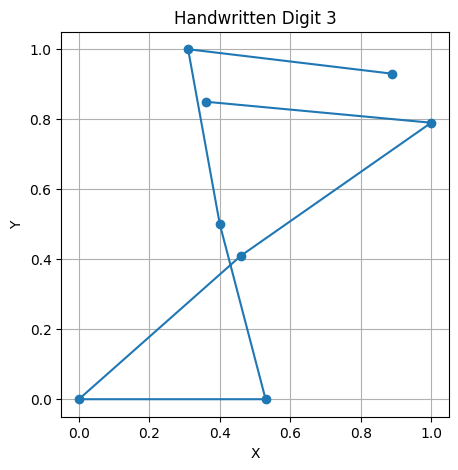

In [17]:
idx = 0
sample = X_test[idx:idx+1]
sample_label = y_test[idx:idx+1]
autoencoded_sample = autoencoder.predict(sample)
visualise_decoded_digit(autoencoded_sample,sample_label)
visualise_digit(X_test,y_test,idx)

In [18]:
from _guided import get_global_weights
PRED_MARGIN_W_LIST = [1]
from help_functions import evaluate
w_type = "global"
pos_label = 1
neg_label = 0

if w_type == "global":
    step_weights = get_global_weights(
        X_train,
        y_train_classes,
        cnnClassifier,
        n_timesteps= n_timesteps,
        n_features=n_features,
        random_state=RANDOM_STATE,
    )
elif w_type == "uniform":
    step_weights = np.ones((1, n_timesteps_padded, n_features))
elif w_type.lower() == "local":
    step_weights = "local"
else:
    raise NotImplementedError(
        "A.w_type not implemented, please choose 'local', 'global' or 'uniform'."
    )
### Evaluation metrics
for pred_margin_weight in PRED_MARGIN_W_LIST:
    print(f"The current prediction margin weight is {pred_margin_weight}.")

    # get the negative predictions, which is class abnormal (0); (normal is class 1)
    X_pred_neg = X_test[y_pred_classes == neg_label][20:30]
    y_pred_neg = y_pred_classes[y_pred_classes==neg_label][10:20]
    lr_list = [0.001]


46/46 [==============================] - 0s 2ms/step
The current prediction margin weight is 1.


In [44]:
import warnings

import numpy as np
import tensorflow as tf
from tensorflow import keras

from wildboar.explain import IntervalImportance
#from LIMESegment.Utils.explanations import LIMESegment


class ModifiedLatentCF:
    """Explanations by generating a counterfacutal sample in the latent space of
    any autoencoder.

    References
    ----------
    Learning Time Series Counterfactuals via Latent Space Representations,
    Wang, Z., Samsten, I., Mochaourab, R., Papapetrou, P., 2021.
    in: International Conference on Discovery Science, pp. 369–384. https://doi.org/10.1007/978-3-030-88942-5_29
    """

    def __init__(
        self,
        probability=0.5,
        *,
        tolerance=1e-6,
        max_iter=100,
        optimizer=None,
        autoencoder=None,
        pred_margin_weight=1.0,  # weighted_steps_weight = 1 - pred_margin_weight
        step_weights="local",
        random_state=None,
        kde = None,
        max_log_likelihood = None,
        min_log_likelihood = None
    ):
        """
        Parameters
        ----------
        probability : float, optional
            The desired probability assigned by the model

        tolerance : float, optional
            The maximum difference between the desired and assigned probability

        optimizer :
            Optimizer with a defined learning rate

        max_iter : int, optional
            The maximum number of iterations

        autoencoder : int, optional
            The autoencoder for the latent representation

            - if None the sample is generated in the original space
            - if given, the autoencoder is expected to have `k` decoder layer and `k`
              encoding layers.
        """
        self.optimizer_ = (
            tf.optimizers.Adam(learning_rate=1e-4) if optimizer is None else optimizer
        )
        self.mse_loss_ = keras.losses.MeanSquaredError()
        self.probability_ = tf.constant([probability])
        self.tolerance_ = tf.constant(tolerance)
        self.max_iter = max_iter
        self.autoencoder = autoencoder

        # Weights of the different loss components
        self.pred_margin_weight = pred_margin_weight
        self.weighted_steps_weight = 1 - self.pred_margin_weight

        self.step_weights = step_weights
        self.random_state = random_state
        self.kde = kde
        self.max_log_likelihood = max_log_likelihood,
        self.min_log_likelihood = min_log_likelihood

    def fit(self, model):
        """Fit a new counterfactual explainer to the model

        Paramaters
        ----------

        model : keras.Model
            The model
        """
        if self.autoencoder:
            (
                encode_input,
                encode_output,
                decode_input,
                decode_output,
            ) = extract_encoder_decoder(self.autoencoder)
            self.decoder_ = keras.Model(inputs=decode_input, outputs=decode_output)
            self.encoder_ = keras.Model(inputs=encode_input, outputs=encode_output)
        else:
            self.decoder_ = None
            self.encoder_ = None
        self.model_ = model
        return self

    def predict(self, x):
        """Compute the difference between the desired and actual probability

        Parameters
        ---------
        x : Variable
            Variable of the sample
        """
        if self.autoencoder is None:
            z = x
        else:
            z = self.decoder_(x)

        return self.model_(z)

    # The "pred_margin_loss" is designed to measure the prediction probability to the desired decision boundary
    def pred_margin_mse(self, prediction):
        return self.mse_loss_(self.probability_, prediction)

    # An auxiliary MAE loss function to measure the proximity with step_weights
    def weighted_mae(self, original_sample, cf_sample, step_weights):
        return tf.math.reduce_mean(
            tf.math.multiply(tf.math.abs(original_sample - cf_sample), step_weights)
        )

    # An auxiliary normalized L2 loss function to measure the proximity with step_weights
    def weighted_normalized_l2(self, original_sample, cf_sample, step_weights):
        var_diff = tf.math.reduce_variance(original_sample - cf_sample)
        var_orig = tf.math.reduce_variance(original_sample)
        var_cf = tf.math.reduce_variance(cf_sample)

        normalized_l2 = 0.5 * var_diff / (var_orig + var_cf)
        return tf.math.reduce_mean(
            tf.math.multiply(
                normalized_l2,
                step_weights,
            )
        )

    # additional input of step_weights
    def compute_loss(self, original_sample, z_search, step_weights, target_label):
        loss = tf.zeros(shape=())
        decoded = self.decoder_(z_search) if self.autoencoder is not None else z_search
        pred = self.model_(decoded)[:, target_label]

        pred_margin_loss = self.pred_margin_mse(pred)
        loss += self.pred_margin_weight * pred_margin_loss

        weighted_steps_loss = self.weighted_mae(
            original_sample=tf.cast(original_sample, dtype=tf.float32),
            cf_sample=tf.cast(decoded, dtype=tf.float32),
            step_weights=tf.cast(step_weights, tf.float32),
        )
        # weighted_steps_loss = self.weighted_normalized_l2(
        #     original_sample=tf.cast(original_sample, dtype=tf.float32),
        #     decoded=tf.cast(decoded, dtype=tf.float32),
        #     step_weights=tf.cast(step_weights, tf.float32)
        # )
        loss += self.weighted_steps_weight * weighted_steps_loss

        return loss, pred_margin_loss, weighted_steps_loss

    # TODO: compatible with the counterfactuals of wildboar
    #       i.e., define the desired output target per label
    def compute_log_likelihood_loss (self, cf_embedding):
      data = cf_embedding[:,:,0]
      transposed_cf_embedding = tf.transpose(data)
      return(np.sum(self.kde.logpdf(transposed_cf_embedding)))


    def transform(self, x, pred_labels):
        """Generate counterfactual explanations

        x : array-like of shape [n_samples, n_timestep, n_dims]
            The samples
        """

        result_samples = np.empty(x.shape)
        losses = np.empty(x.shape[0])
        # `weights_all` needed for debugging
        weights_all = np.empty((x.shape[0], 1, x.shape[1], x.shape[2]))

        for i in range(x.shape[0]):
            if i % 25 == 0:
                print(f"{i+1} samples been transformed.")

            # if self.step_weights == "global" OR "uniform"
            if isinstance(self.step_weights, np.ndarray):  #  "global" OR "uniform"
                step_weights = self.step_weights
            elif self.step_weights == "local":
                # ignore warning of matrix multiplication, from LIMESegment: `https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice`
                # ignore warning of scipy package warning, from LIMESegment: `https://github.com/paulvangentcom/heartrate_analysis_python/issues/31`
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    warnings.simplefilter("ignore", category=UserWarning)
                    step_weights = get_local_weights(
                        x[i],
                        self.model_,
                        random_state=self.random_state,
                        pred_label=pred_labels[i],
                    )
            else:
                raise NotImplementedError(
                    "step_weights not implemented, please choose 'local', 'global' or 'uniform'."
                )

            # print(step_weights.reshape(-1))
            x_sample, loss = self._transform_sample(
                x[np.newaxis, i], step_weights, pred_labels[i]
            )

            result_samples[i] = x_sample
            losses[i] = loss
            weights_all[i] = step_weights

        print(f"{i+1} samples been transformed, in total.")

        return result_samples, losses, weights_all

    def _transform_sample(self, x, step_weights, pred_label):
        """Generate counterfactual explanations(z))"""
        # TODO: check_is_fitted(self)
        if self.autoencoder is not None:
            z = tf.Variable(self.encoder_(x))
        else:
            z = tf.Variable(x, dtype=tf.float32)

        it = 0
        target_label = 1 - pred_label  # for binary classification

        with tf.GradientTape() as tape:
            loss, pred_margin_loss, weighted_steps_loss = self.compute_loss(
                x, z, step_weights, target_label
            )
        log_likelihood = self.compute_log_likelihood_loss(self.decoder_(z))
        if self.autoencoder is not None:
            pred = self.model_(self.decoder_(z))
        else:
            pred = self.model_(z)

        # # uncomment for debug
        # print(
        #     f"current loss: {loss}, pred_margin_loss: {pred_margin_loss}, weighted_steps_loss: {weighted_steps_loss}, pred prob:{pred}, iter: {it}."
        # )

        # TODO: modify the loss to check both validity and proximity; how to design the condition here?
        # while (pred_margin_loss > self.tolerance_ or pred[:, 1] < self.probability_ or weighted_steps_loss > self.step_tolerance_)?
        # loss > tf.multiply(self.tolerance_rate_, loss_original)
        while (
            pred_margin_loss > self.tolerance_
            or pred[:, target_label] < self.probability_
        ) and (it < self.max_iter if self.max_iter else True
        ) or not (self.min_log_likelihood < log_likelihood < self.max_log_likelihood):
            # Get gradients of loss wrt the sample
            grads = tape.gradient(loss, z)
            # Update the weights of the sample
            self.optimizer_.apply_gradients([(grads, z)])

            with tf.GradientTape() as tape:
                loss, pred_margin_loss, weighted_steps_loss = self.compute_loss(
                    x, z, step_weights, target_label
                )
            log_likelihood = self.compute_log_likelihood_loss(self.decoder_(z))
            it += 1

            if self.autoencoder is not None:
                pred = self.model_(self.decoder_(z))
            else:
                pred = self.model_(z)

        # # uncomment for debug
        # print(
        #     f"current loss: {loss}, pred_margin_loss: {pred_margin_loss}, weighted_steps_loss: {weighted_steps_loss}, pred prob:{pred}, iter: {it}. \n"
        # )

        res = z.numpy() if self.autoencoder is None else self.decoder_(z).numpy()
        return res, float(loss)


def extract_encoder_decoder(autoencoder):
    """Extract the encoder and decoder from an autoencoder

    autoencoder : keras.Model
        The autoencoder of `k` encoders and `k` decoders
    """
    depth = len(autoencoder.layers) // 2
    encoder = autoencoder.layers[1](autoencoder.input)
    for i in range(2, depth):
        encoder = autoencoder.layers[i](encoder)

    encode_input = keras.Input(shape=encoder.shape[1:])
    decoder = autoencoder.layers[depth](encode_input)
    for i in range(depth + 1, len(autoencoder.layers)):
        decoder = autoencoder.layers[i](decoder)

    return autoencoder.input, encoder, encode_input, decoder


# def get_local_weights(
#     input_sample, classifier_model, random_state=None, pred_label=None
# ):
#     n_timesteps, n_dims = input_sample.shape  # n_dims=1
#     # for binary classification, default to 1
#     desired_label = int(1 - pred_label) if pred_label is not None else 1
#     seg_imp, seg_idx = LIMESegment(
#         input_sample,
#         classifier_model,
#         model_type=desired_label,
#         cp=10,
#         window_size=10,
#         random_state=random_state,
#     )

#     if desired_label == 1:
#         # calculate the threshold of masking, lower 25 percentile (neg contribution for pos class)
#         masking_threshold = np.percentile(seg_imp, 25)
#         masking_idx = np.where(seg_imp <= masking_threshold)
#     else:  # desired_label == 0
#         # calculate the threshold of masking, upper 25 percentile (pos contribution for neg class)
#         masking_threshold = np.percentile(seg_imp, 75)
#         masking_idx = np.where(seg_imp >= masking_threshold)

#     weighted_steps = np.ones(n_timesteps)
#     for start_idx in masking_idx[0]:
#         weighted_steps[seg_idx[start_idx] : seg_idx[start_idx + 1]] = 0

#     # need to reshape for multiplication in `tf.math.multiply()`
#     weighted_steps = weighted_steps.reshape(1, n_timesteps, n_dims)
#     return weighted_steps


def get_global_weights(
    input_samples, input_labels, classifier_model, n_timesteps, n_features, random_state=None,
):
    n_samples, n_timesteps, n_dims = input_samples.shape  # n_dims=1

    class ModelWrapper:
        def __init__(self, model, n_timesteps, n_features):
            self.model = model
            self.fitted_ = False
            self.n_timesteps_in_ = n_timesteps*n_features
            self.n_features_in_ = n_features/n_features

        def predict(self, X):
            p = self.model.predict(X.reshape(n_samples, n_timesteps, n_features))
            return np.argmax(p, axis=1)

        def fit(self, X, y):

          self.fitted_ = True
          return self.model.fit(X, y)

    clf = ModelWrapper(classifier_model, n_timesteps, n_features)

    i = IntervalImportance(scoring="accuracy",n_intervals=16, random_state=random_state)
    i.fit(clf, input_samples.reshape(input_samples.shape[0], -1), input_labels)

    # calculate the threshold of masking, 75 percentile
    masking_threshold = np.percentile(i.importances_.mean, 75)
    masking_idx = np.where(i.importances_.mean >= masking_threshold)

    weighted_steps = np.ones(n_timesteps*n_features)
    seg_idx = i.components_
    for start_idx in masking_idx[0]:
        weighted_steps[seg_idx[start_idx][0] : seg_idx[start_idx][1]] = 0

    # need to reshape for multiplication in `tf.math.multiply()`
    weighted_steps = weighted_steps.reshape(1, n_timesteps, n_features)
    return weighted_steps

In [41]:
#training KDE on eights
from scipy.stats import gaussian_kde
kde_dim_1 = X_train[y_train_classes == 1][:,:,0]
kde_dim_2 = X_train[y_train_classes == 1][:,:,1]
kde_1 = gaussian_kde(kde_dim_1.T,)
kde_2 = gaussian_kde(kde_dim_2.T,)

print("Testing KDE with eights.\n")
for i in range (5):
  test_dim_1 =  X_train[y_train_classes == 1][i,:,0]
  test_dim_2 =  X_train[y_train_classes == 1][i,:,1]
  print(f'Data: {i + 1}')
  print(f'Log likelihood of x-feature: {kde_1.logpdf(test_dim_1.T).round(2)}')
  print(f'Log likelihood of y-feature: {kde_2.logpdf(test_dim_2.T).round(2)}\n')

print("Testing KDE with zeros.\n")
for i in range (5):
  test_dim_1 =  X_test[y_test_classes == 0][i,:,0]
  test_dim_2 =  X_test[y_test_classes == 0][i,:,1]
  print(f'Data: {i + 1}')
  print(f'Log likelihood of x-feature: {kde_1.logpdf(test_dim_1.T).round(2)}')
  print(f'Log likelihood of y-feature: {kde_2.logpdf(test_dim_2.T).round(2)}\n')

Testing KDE with eights.

Data: 1
Log likelihood of x-feature: [3.69]
Log likelihood of y-feature: [10.07]

Data: 2
Log likelihood of x-feature: [2.8]
Log likelihood of y-feature: [10.62]

Data: 3
Log likelihood of x-feature: [3.95]
Log likelihood of y-feature: [9.48]

Data: 4
Log likelihood of x-feature: [3.49]
Log likelihood of y-feature: [9.71]

Data: 5
Log likelihood of x-feature: [2.92]
Log likelihood of y-feature: [10.38]

Testing KDE with zeros.

Data: 1
Log likelihood of x-feature: [-10.48]
Log likelihood of y-feature: [6.86]

Data: 2
Log likelihood of x-feature: [-1.66]
Log likelihood of y-feature: [8.73]

Data: 3
Log likelihood of x-feature: [-3.87]
Log likelihood of y-feature: [8.72]

Data: 4
Log likelihood of x-feature: [-6.65]
Log likelihood of y-feature: [8.72]

Data: 5
Log likelihood of x-feature: [-6.79]
Log likelihood of y-feature: [5.35]



In [21]:
max_log_likelihood = np.max(kde_1.logpdf(X_train[y_train_classes == 1][:,:,0].T))
min_log_likelihood = np.min(kde_1.logpdf(X_train[y_train_classes == 1][:,:,0].T))
print(f'Max log_likelihood = {max_log_likelihood}')
print(f'Min log_likelihood = {min_log_likelihood}')

Max log_likelihood = 4.203043678068669
Min log_likelihood = 2.101195504943621


In [21]:
def compute_log_likelihood_loss (kde, cf_embedding):
  data = cf_embedding[:,:,0]
  return(np.sum(kde.logpdf(data.T)))

loss = compute_log_likelihood_loss(kde_1, ...)
loss

In [45]:
reset_seeds()
cf_model = ModifiedLatentCF(
    probability=0.9,tolerance=1e-6, max_iter=1000, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),autoencoder = autoencoder,
    pred_margin_weight=1, step_weights = step_weights, random_state= RANDOM_STATE,kde = kde_1, max_log_likelihood = max_log_likelihood, min_log_likelihood = min_log_likelihood
    )
cf_model.fit(cnnClassifier)

y_neg = y_train_classes[y_train_classes == 0][10:15]
X_neg = X_train[y_train_classes == 0][10:15]


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning) # ignore warning of matrix multiplication: https://stackoverflow.com/questions/29688168/mean-nanmean-and-warning-mean-of-empty-slice
    cf_embeddings, losses, weights = cf_model.transform(X_neg, y_neg) #self, x, pred_label
z_pred = cnnClassifier.predict(cf_embeddings)[:, 1] # predicted probabilities of CFs

#evaluate_res = evaluate(X_pred_neg, best_cf_samples, z_pred, n_timesteps, tree, max_distance)
#evaluate_res #  proximity, validity, cost_mean, cost_std

#print(f'Transformation_finished with validity_score = {validity_score(y_neg_classes,cf_pred_labels)}')

1 samples been transformed.


KeyboardInterrupt: ignored

In [38]:
print("Testing KDE with eights.\n")
for i in range (5):
  test_dim_1 =  cf_embeddings[i,:,0]
  test_dim_2 =  cf_embeddings[i,:,1]
  print(f'Counterfactual: {i+1}')
  print(f'Log likelihood of x-feature: {np.sum(kde_1.logpdf(test_dim_1.T))}')
  print(f'Log likelihood of y-feature: {np.sum(kde_2.logpdf(test_dim_2.T))}\n')

Testing KDE with eights.

Counterfactual: 1
Log likelihood of x-feature: -8.057648068158324
Log likelihood of y-feature: 6.661984389110959

Counterfactual: 2
Log likelihood of x-feature: -6.525372469898664
Log likelihood of y-feature: -24.11487250244242

Counterfactual: 3
Log likelihood of x-feature: -4.954282399550403
Log likelihood of y-feature: -25.465941489564877

Counterfactual: 4
Log likelihood of x-feature: -8.883691741107464
Log likelihood of y-feature: 5.450313218846297

Counterfactual: 5
Log likelihood of x-feature: -3.041381903854571
Log likelihood of y-feature: 7.383739029388246



In [ ]:
#with learning rate = 0.001 and 500 iterations
for i in range(5):
  print("actual")
  visualise_digit(X_pred_neg,y_pred_neg,i,figsize = (5,5))
  print("counterfactual")
  visualise_digit(cf_embeddings,y_neg,i,figsize = (5,5))


In [ ]:
#with learning rate = 0.001 and 1000 iterations
for i in range(6):
  print("actual")
  visualise_digit(X_pred_neg,y_pred_neg,i-1,figsize = (5,5))
  print("counterfactual")
  visualise_digit(cf_embeddings,y_neg,i-1,figsize = (5,5))

In [ ]:
#with learning rate = 0.0001 and 500 iterations
for i in range(6):
  print("actual")
  visualise_digit(X_pred_neg,y_pred_neg,i-1,figsize = (5,5))
  print("counterfactual")
  visualise_digit(cf_embeddings,y_neg,i-1,figsize = (5,5))